In [96]:
import scipy.io
from scipy.sparse import *
from scipy import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linalg as LA
import sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import random
import string
import os
import re
import math
import json
import time

In [19]:
# Load the beer review data from 'labeled.json'
beer_review_df = pd.read_json('labeled.json', lines = True)

Part I Data Inspection

In [20]:
# Check the mean, median and standard deviation of the overall ratings
overll_mean = beer_review_df["overall"].mean()
overll_median = beer_review_df["overall"].median()
overll_std = beer_review_df["overall"].std()

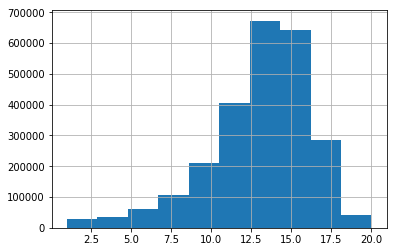

In [21]:
# Plot the ooverall ratings distribution
beer_review_df["overall"].hist()
plt.show()

In [22]:
# Print the mean, median, standard deviation of the overall ratings 
print("Statistics of the overall ratings:")
print("Mean: " + str(overll_mean))
print("Median: " + str(overll_median))
print("Standard deviation: " + str(overll_std))

Statistics of the overall ratings:
Mean: 13.198879641948754
Median: 14.0
Standard deviation: 3.352351483317063


The mean (14.0) and the median (13.2) is close, indicating that the ratings are concentrated and without many outliers. The standard deviation is around 3, indicating the variation of people's ratings. The ratings are centered at the high score range (14.0). The number of extreme ratings like 20.0 or <5.0 is low. Most people give intermediate scores in the range of 10-17.5. 

Part III Sentiment Analysis

(a) Generating Features

In [23]:
# Function to normalize the text and separate into space delimited tokens
def clean_and_split(s):
    # encode to UTF-8, convert to lowercase and translate all hyphens and
    # punctuation to whitespace
    s = s.lower().replace('-',' ').translate(string.punctuation)
    # replace \r\n
    s = re.sub('(\r\n)+',' ',s)
    # replace whitespace substrings with one whitespace and remove
    # leading/trailing whitespaces
    s = re.sub(' +',' ',s.strip())
    return s.split(' ')

In [24]:
# Clean and split the reviews
start = time.time()
beer_review_df["clean_text"] = beer_review_df["review"].apply(clean_and_split)
end = time.time()
print("Time elapsed: ", end-start)

Time elapsed:  937.9917941093445


In [25]:
# Load the vocabulary file
with open('vocab_50.json') as f:
    vocab = json.load(f)

In [26]:
### REFRENCE: Yihan Zhang ###
# Get the row and column index of the 1's in the sparse matrix
start = time.time()
vocab_index_dict = {x:i for i,x in enumerate(vocab)}
reviews = pd.DataFrame(beer_review_df["clean_text"])
row_ind = []
col_ind = []
for row in reviews.itertuples():
    for word in set(row.clean_text):
        if word in vocab_index_dict:
            row_ind.append(row.Index)
            col_ind.append(vocab_index_dict[word])
end = time.time()
print("Time elapsed: ", end-start)

Time elapsed:  115.52337980270386


In [27]:
# Generate the features sparse matrix for all the reviews
# Fill up 1's at the indices in row_ind and col_ind
features = csr_matrix((np.ones(len(row_ind)),(row_ind,col_ind)),shape=(len(beer_review_df),len(vocab)),dtype = np.int8)

In [28]:
# Use 14 as cutoff point to classfiy overall review (1 if overal >= 14, 0 otherwise)
beer_review_df["overall_binary"] = beer_review_df["overall"].apply(lambda x: 1 if x >= 14 else 0)

In [98]:
# Split the data into training, validation and testing sets with proportion 0.7:0.15:0.15
# First separate the training data of proportion 0.7 from validation and test data
X_train,X_valtest,Y_train,Y_valtest = train_test_split(features,beer_review_df["overall_binary"],train_size=0.7, random_state = 12345)

# Next separate the validation and test half and half
X_validation,X_test,Y_validation,Y_test = train_test_split(X_valtest,Y_valtest,train_size = 0.5,random_state = 12345)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(b) Logistic Regression Using Newton’s method.

In [30]:
# Train an l2-regularized logistic regression classifier
# Create the logistic regression class
# After experiment, regularization parameter C = 0.01 is the best 
start = time.time()
C = 0.01
LR = LogisticRegression(C = C, penalty='l2')
LR.fit(X_train, Y_train)
end = time.time()
print("Time elapsed: ", end-start)

Time elapsed:  147.70592093467712


In [31]:
# Prediction on X_validation
y_val_pred = LR.predict(X_validation)

In [32]:
# Creating the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_validation, y_val_pred)

In [33]:
# Compute the error rate
er = (cm[0,1]+cm[1,0])/cm.sum()
print("Error Rate at C =", C, "is", er)

Error Rate at C = 0.01 is 0.2348827731182565


In [34]:
# Experiment with different regularization parameter C
C_lgr = 0.01
exp_LR = LogisticRegression(C = C_lgr, penalty='l2')
exp_LR.fit(X_train, Y_train)

# Prediction on X_validation
exp_y_val_pred = exp_LR.predict(X_validation)

# Create confusion matrix
exp_cm = confusion_matrix(Y_validation, exp_y_val_pred)

# Compute the error rate
er = (cm[0,1]+cm[1,0])/cm.sum()
print("Error Rate at C_lgr =", C_lgr, "is", er)

Error Rate at C = 0.01 is 0.2348827731182565


In [99]:
# Train the data with LinearSVC
SVC = LinearSVC(loss='hinge')
SVC.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [100]:
# Create the confusion matrix and compute error rate
y_pred_svc = SVC.predict(X_validation)
cm_svc = confusion_matrix(Y_validation,y_pred_svc)
er_svc = (cm_svc[0,1] + cm_svc[1,0])/cm_svc.sum()
print("Error Rate is", er_svc)

Error Rate is 0.23315064673201913


In [101]:
# Experiment with different regularization parameter C
C_svc = 0.01
exp_SVC = LinearSVC(loss='hinge', C = C_svc)
exp_SVC.fit(X_train, Y_train)

# Prediction on X_validation
exp_y_val_pred_svc = exp_SVC.predict(X_validation)

# Create confusion matrix
exp_cm_svc = confusion_matrix(Y_validation, exp_y_val_pred_svc)

# Compute the error rate
exp_er_svc = (exp_cm_svc[0,1]+exp_cm_svc[1,0])/exp_cm_svc.sum()
print("Error Rate at C_svc =", C_svc, "is", exp_er_svc)

Error Rate at C_svc = 0.01 is 0.2339711276518158


There is not much difference in the logistic loss and hinge loss. The choice of regularization parameter C between 0 an 1 doesn't pose much influence on neither the logistic loss nor the hinge loss.

(c) Stochastic Gradient Descent

In [35]:
# Function that computes the error rate 
def compute_error(X, Y, w,b):
    if type(X) == type(Y):
        z = np.dot(X,w) + b
    else:
        z = X*w + b
    a = np.reciprocal(1 + np.exp((-1)*z))
    b = np.array(a)
    flag = lambda x : 1 if x >0.5 else 0
    y_pred = np.vectorize(flag)(b)
    cm = confusion_matrix(Y,y_pred)
    error = (cm[0,1]+cm[1,0])/cm.sum()
    print("error rate is " + str(error))
    return error

In [79]:
# Function that computes the negative log likelihood
def compute_neglog_likelihood(X, Y, w, b, m):
    if type(X) == type(Y):
        z = np.dot(X,w) + b
    else:
        z = X*w + b
    a = np.reciprocal(1 + np.exp((-1)*z))
    loga = np.log(a)
    neglog = float((-1/m)*(Y.transpose().dot(np.log(a)) + (1-Y).transpose().dot(np.log(1-a))))
    return neglog

In [80]:
# Function that trains an l2-regularized logistic regression classifier using stochastic gradient descent
# After experiment, constant learning rate r = 0.6/(t+1) gives the lowest error rate
# After experiment, regularization parameter alpha = 0.0001 gives the best result
def lg_sgd(X, Y, num_epoch = 10, minibatch_size = 1500, alpha = 0.0001):
    
    if type(X) == type(Y):
        num_features = 5
    else:
        num_features = 30009
    w = np.array([np.zeros(num_features)]).transpose()
    b = -5
    
    num_minibatch = Y.shape[0] // minibatch_size
    
    error = []
    neglog = []
    for t in range(num_epoch):
        r = 0.6/(t+1)
        
        arr = np.arange(Y.shape[0])
        np.random.shuffle(arr)
    
        for j in range(num_minibatch+1):
            index = arr[j:j+minibatch_size]
            minix = X[index]
            miniy = Y[index]
            
            if type(X) == type(Y):
                z = np.dot(minix,w) + b
            else:
                z = minix*w + b

            a = 1/(1+np.exp(-1*z))
            dl = (-1/minibatch_size)*(miniy*(1/a) - (1-miniy)*(1/(1-a)))
            
            da = np.exp(z)/((1+np.exp(z))*(1+np.exp(z)))
            u = dl*da
           
            if type(X) == type(Y):
                dw = np.multiply(minix, u).sum(axis=0) + (alpha/minibatch_size)*w.transpose()
            else: 
                dw = np.array(minix.multiply(u).sum(axis=0)) + (alpha/minibatch_size)*w.transpose()
            w = w - r*dw.transpose()
            
            db = u.sum()
            b = b - r*db
            
        error.append(compute_error(X,Y,w,b))
        neglog.append(compute_neglog_likelihood(X, Y, w,b,Y.shape[0]))
    return w, b, error, neglog

In [62]:
# Convert Y to the numpy array format
Y_train = np.array([Y_train]).transpose()
Y_validation = np.array([Y_validation]).transpose()
Y_test = np.array([Y_test]).transpose()

In [63]:
xtest = X_test[:500,:]
ytest = np.array([Y_test[:500]]).transpose()

In [64]:
# Concatenate the training and validation data
from scipy.sparse import hstack
X_trainval = hstack([X_train.transpose(),X_validation.transpose()]).transpose()
Y_trainval = np.concatenate((Y_train,Y_validation), axis = 0)

In [81]:
# Train the model on both training and validation data
start = time.time()
w_text_trainval, b_text_trainval, error, neglog = lg_sgd(X_trainval, Y_trainval)
end = time.time()
print("Time elapsed: ", end-start)

error rate is 0.3085892604080165
error rate is 0.2943477201375039
error rate is 0.285557124910393
error rate is 0.2813681304252163
error rate is 0.27634351363564313
error rate is 0.28257850520134664
error rate is 0.27618973263398466
error rate is 0.2717471177891497
error rate is 0.26964575954802583
error rate is 0.2684737117292319
Time elapsed:  82.8669970035553


In [82]:
neglog

[0.615501819239318,
 0.596254355251678,
 0.5737274074643025,
 0.5682114696960102,
 0.5559213338667616,
 0.5574424881670557,
 0.5500632854092957,
 0.5436327110992669,
 0.5381251967520827,
 0.5367834947325337]

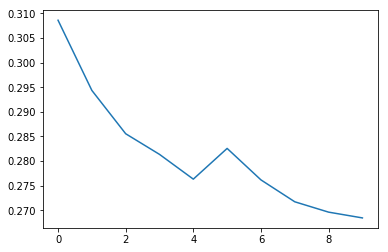

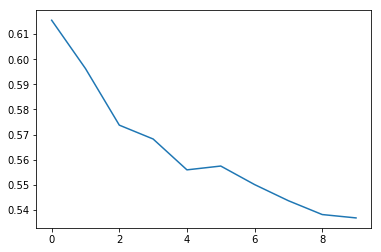

In [83]:
# Plot the error rate and negative log likelihood for each 150 iterations
plt.plot(error)
plt.show()
plt.plot(neglog)
plt.show()

The error rate and negative log likelihood were computed and plotted at the end of each epoch (10 epochs in total). There is a clear trend of decreasing in both values.

In [84]:
# Compute the error rate on test set
compute_error(X_test, Y_test, w_text_trainval, b_text_trainval)

error rate is 0.26839038699246287


0.26839038699246287

The SGD is much faster than the Logistic regression function in the previous part. The SDG takes ~82 seconds but the Logistic regression function in the previous part takes ~147 seconds. The SGD gives a little bit higher error rate (~0.29) than the Logistic regression function in previous part (~0.23). 

PART III Scores Versus Text

In [86]:
# Standardize the scores
appearance_mean, aroma_mean, style_mean, taste_mean, palate_mean = beer_review_df["appearance"].mean(),\
    beer_review_df["aroma"].mean(), beer_review_df["style"].mean(), beer_review_df["taste"].mean(),\
    beer_review_df["palate"].mean()
    
appearance_sd, aroma_sd, style_sd, taste_sd, palate_sd = beer_review_df["appearance"].std(),\
    beer_review_df["aroma"].std(), beer_review_df["style"].std(), beer_review_df["taste"].std(),\
    beer_review_df["palate"].std()

stand_appearance = beer_review_df["appearance"].apply(lambda x: (x-appearance_mean)/appearance_sd)
stand_aroma = beer_review_df["aroma"].apply(lambda x: (x-aroma_mean)/aroma_sd)
stand_style = beer_review_df["style"].apply(lambda x: (x-style_mean)/style_sd)
stand_taste = beer_review_df["taste"].apply(lambda x: (x-taste_mean)/taste_sd)
stand_palate = beer_review_df["palate"].apply(lambda x: (x-palate_mean)/palate_sd)

In [87]:
# Create matrix with the five scores as features
scores = np.array([stand_appearance,stand_aroma, stand_style,stand_taste,stand_palate]).transpose()

In [88]:
scores.shape

(2486348, 5)

In [89]:
# Split the data into training, validation and testing sets with proportion 0.7:0.15:0.15
# First separate the training data of proportion 0.7 from validation and test data
ScoresX_train,ScoresX_valtest, ScoresY_train, ScoresY_valtest = train_test_split(scores, beer_review_df["overall_binary"], train_size=0.7, random_state = 12345)

# Next separate the validation and test half and half
ScoresX_validation,ScoresX_test,ScoresY_validation,ScoresY_test = train_test_split(ScoresX_valtest,ScoresY_valtest,train_size = 0.5,random_state = 12345)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [90]:
# Convert Y to the numpy array format
ScoresY_train = np.array([ScoresY_train]).transpose()
ScoresY_validation = np.array([ScoresY_validation]).transpose()
ScoresY_test = np.array([ScoresY_test]).transpose()

In [91]:
# Concatenate the training and validation data
ScoresX_trainval = np.concatenate((ScoresX_train,ScoresX_validation), axis = 0)
ScoresY_trainval = np.concatenate((ScoresY_train,ScoresY_validation), axis = 0)

In [92]:
# Train the model on the training set and experiment with parameters on the validation set
w_train, b_train, error, neglog = lg_sgd(ScoresX_train, ScoresY_train)
compute_error(ScoresX_validation, ScoresY_validation, w_train, b_train)

error rate is 0.14759058469596534
error rate is 0.14470913439854105
error rate is 0.1455686856737049
error rate is 0.14659715945882743
error rate is 0.14686490738277552
error rate is 0.14732168763929643
error rate is 0.147536000891727
error rate is 0.14639203926816333
error rate is 0.147285489958591
error rate is 0.14626678380159533
error rate is 0.1456434071944915


0.1456434071944915

In [93]:
# Train the model on both training and validation set with the optimized parameters
w_trainval, b_trainval, error, neglog = lg_sgd(ScoresX_trainval, ScoresY_trainval)

error rate is 0.1462045665859908
error rate is 0.1469266275353164
error rate is 0.14612318094819
error rate is 0.14776224983971287
error rate is 0.1457806041937262
error rate is 0.14488488900560473
error rate is 0.14913586906375761
error rate is 0.14662237773818904
error rate is 0.14653010913719394
error rate is 0.1462944693254219


In [94]:
# Report the error on the test set
compute_error(ScoresX_test, ScoresY_test,w_trainval,b_trainval)

error rate is 0.14545800677297138


0.14545800677297138

Which model predicts better? Is the representation you constructed for text more powerful, or are the scores? Why? Comment on your findings and discuss your thinking.

The scores predict better than the text because it gives smaller error rate (~0.14) than the text does (~0.26). One of the reasons for the higher error rate of text prediction is that the vocaubulary could not catch the sarcastism perfectly. For example, there might be positive words in the review but preceeded or followed by some other words that suggest sarcastism. With our method, we will detect only the positive words but not considering the context of it. This might result in miss interpretation of the review. However, the scores give more powerful prediction partly because the scores of each feature is by itself related to the overall rating. It is unlikely that someone will give high scores on each feature but low score for the overall. There is still chance of misprediction because it could happen that someone give high scores to some features but low scores to others. It is then hard to predict the overall because we don't take into account of individual differences in the weights on each feature. 